In [160]:
using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));

cs2 = ColorScheme(range(colorant"red", colorant"royalblue1", length=7));

using QuadGK

using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [161]:
include("qts.jl")
include("brentq.jl")
include("fields.jl")

psi_s_case_E (generic function with 1 method)

# Parameters

In [162]:
const rho = 1.5
const gamma = 5000.0
const phi = 0.2

const beta = (1-1/gamma^2)^(1/2)
# lamb = 0.01/rho

# const phi_m = 0.5/rho

const sigma_z = 50e-6
const sigma_x = 50e-6

lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2) 

lamb_2d (generic function with 1 method)

# Functions

In [163]:
function QTS_case_B(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, xp::Float64)
    
    ## define function here
    #sigma_x  = 50e-6
    #sigma_z  = 50e-6
    #lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)    

    ## integral    
    #iii(z::Float64) =  Fx_case_B_SC((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma)*lamb_2d(z,xp)
    iii(z::Float64) =  Es_case_B((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma)*lamb_2d(z,xp)
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zi = rho*(phi - beta*sqrt(chi^2 + 4*(1 + chi)*sin(phi/2)^2))
    zo = -beta*abs(x_ob - xp)

#####################################
    # find critical alpha

    # These came from Es_case_B

    kap(alp::Float64) = sqrt(chi^2 + 4*(1+chi)*sin(alp)^2)
    
    #N1(alp::Float64) = sin(2*alp) - beta*kap(alp)
    N2(alp::Float64) = (1+chi)*sin(2*alp) - beta*kap(alp)
    #D(alp::Float64) = kap(alp) - beta*(1+chi)*sin(2*alp)

    alp_crit2_found = true
    
    alp_crit2 = find_root_Will(N2, 0.0, 0.03, 2000)
    
    if alp_crit2 == -1.0
       alp_crit2_found = false
    end

    #println("alp_crit2: ", alp_crit2)
    
    alp_crit2_usable = false

    if alp_crit2_found == true
        z_crit2  = z_ob - 2*rho*(alp_crit2 - beta*kap(alp_crit2)/2)  
        if (z_crit2 > z_ob - zi) && (z_crit2 < z_ob - zo)
            alp_crit2_usable = true
        end
    end        
        
    
    # TESTING
    if (alp_crit2_usable == true)
        #println("ONLY USING N2 BP :", alp_crit2, ",  ",  z_crit2)


        zp2 = z_crit2
    
        i1 = QTS_will(iii, z_ob - zi, zp2)  
        i2 = QTS_will(iii, zp2, z_ob - zo) 
        
        return i1+i2
        
    else
        
        if (z_ob - zi < 0.0) && (0.0 < z_ob - zo)
            
            #return QTS_will(iii, z_ob - zi, z_ob - zo) 
            
            #println("USING ZERO!!!")
            i1 = QTS_will(iii, z_ob - zi, 0.0) 
            i2 = QTS_will(iii, 0.0, z_ob - zo) 
            return i1 + i2
            
        else
            #println("USING NO BP!!!")
            return QTS_will(iii, z_ob - zi, z_ob - zo) 
            
        end
        
    end
    
end 

QTS_case_B (generic function with 1 method)

In [164]:
QTS_case_B(1E-6, 1E-6, gamma, 0.02, 0.0)

-1.924483385735016e10

In [165]:
function compute_Ws_case_B(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, nxp::Int)
    #sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #for testing only
    #qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #println("xp_vec:", xp_vec[i])
        #qvec[i] = QTS_case_B_2(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        sum += QTS_case_B(z_ob, x_ob, gamma, phi, xp_vec[i])   # for CPU only
        
    end
    
    #return qvec
    return sum* dxp*beta^2/rho^2
end

compute_Ws_case_B (generic function with 1 method)

In [166]:
compute_Ws_case_B(0.0, 0.0, gamma, 0.2, 101)

-230305.1639999532

# Wake computation with GPU

#### simple test (4 observation points only)

In [94]:
zo_vec = CuArray([0.0, 1E-6, 2E-6, 3E-6])
#int_vec = similar(zo_vec)
Ws_vec = similar(zo_vec)

function qts_gpu!(Ws_vec, zo_vec::CuDeviceArray)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(zo_vec)
        #f(z) = (z-zo_vec[i])^2  # test function with zo as a parameter
        Ws_vec[i] = compute_Ws_case_B(Ws_vec[i], 0.0, gamma, phi, 101)
        #int_vec[i] = QTS_case_B(zo_vec[i], 0.0, gamma, 0.2, 0.0) 
    end
    return nothing
end

@cuda threads=4 qts_gpu!(Ws_vec, zo_vec)

CUDA.HostKernel{typeof(qts_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}}}(qts_gpu!, CuContext(0x0000000004d31ea0, instance 847efd65a6fe70ac), CuModule(Ptr{Nothing} @0x000000000e954db0, CuContext(0x0000000004d31ea0, instance 847efd65a6fe70ac)), CuFunction(Ptr{Nothing} @0x000000000e545490, CuModule(Ptr{Nothing} @0x000000000e954db0, CuContext(0x0000000004d31ea0, instance 847efd65a6fe70ac))), CUDA.KernelState(Ptr{Nothing} @0x00007f8f58400000))

### 2D observation grid definition 

In [167]:
nz = 201
nx = 101
AA = CuArray{Float64}(undef, nz, nx);

In [168]:
zv = LinRange(-5*sigma_z, 5*sigma_z, nz);
xv = LinRange(-5*sigma_x, 5*sigma_x, nx);

In [169]:
sigma_z = 50e-6
sigma_x = 50e-6

dz = (5*sigma_z - (-5*sigma_z))/(nz-1)
dx = (5*sigma_x - (-5*sigma_x))/(nx-1)

Δ = (dz, dx)

(2.5e-6, 5.0e-6)

### GPU computation ( indexing template from Chris Mayes )

In [170]:
function fillwake!(A::CuDeviceArray, Δ)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    dz, dx = Δ
    nz, nx =  size(A) 
    for i = index:stride:length(A)
        ij = @inbounds CartesianIndices(A)[i]

        z = dz*(ij[1]-1 - (nz-1)/2)
        x = dx*(ij[2]-1 - (nx-1)/2)

        #@inbounds A[i] = f(z, x)
        
        @inbounds A[i] = compute_Ws_case_B(z, x, gamma, phi, 101)
    end
    
end

fillwake! (generic function with 1 method)

In [154]:
# GPU parameters

Ncu = length(AA)
kernel = @cuda launch=false fillwake!(AA, Δ)
config = launch_configuration(kernel.fun)
threads = min(Ncu, config.threads)
blocks = cld(Ncu, threads)
threads, blocks

(256, 80)

In [155]:
# Fill on the device
# This cell can take time!

CUDA.@time CUDA.@sync kernel(AA, Δ; threads, blocks);

 26.900161 seconds (98 CPU allocations: 5.109 KiB)


In [156]:
AA_cpu = Array(AA);

In [72]:
CUDA.@sync kernel(AA, Δ; threads, blocks);

In [15]:
# How William ran gpu

#function bench_gpu2!(AA, Δ)
#    CUDA.@sync begin
#        @cuda threads=1024 blocks=cld(length(AA), 1024) fillwake!(AA, Δ)
#    end
#end

#@time bench_gpu2!(AA, Δ)

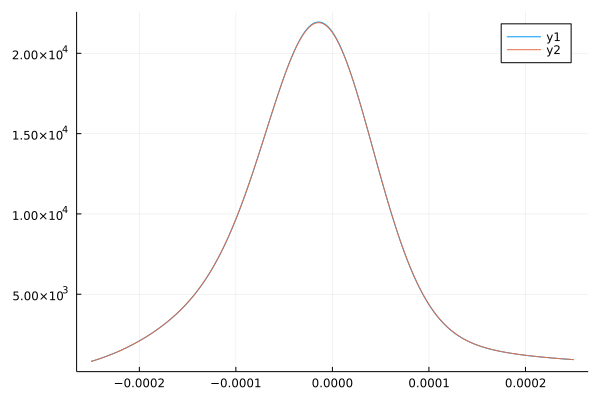

In [84]:
plot(zv, AA_cpu[:,11])
plot!(zv, AA_cpu[:,91])

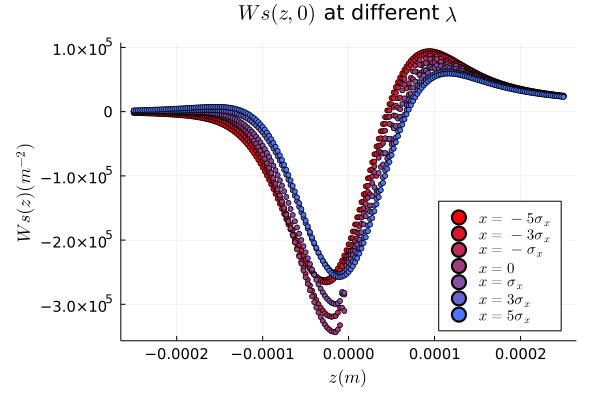

In [159]:
plot(zv, AA_cpu[:,1], linewidth=2, label=L"x=-5\sigma_x", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zv, AA_cpu[:,21], linewidth=2, label=L"x=-3\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[2])
plot!(zv, AA_cpu[:,41], linewidth=2, label=L"x=-\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[3])
plot!(zv, AA_cpu[:,51], linewidth=2, label=L"x=0", markersize = 3, seriestype = :scatter, color=cs2[4])
plot!(zv, AA_cpu[:,61], linewidth=2, label=L"x=\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[5])
plot!(zv, AA_cpu[:,81], linewidth=2, label=L"x=3\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[6])
plot!(zv, AA_cpu[:,101], linewidth=2, label=L"x=5\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[7])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

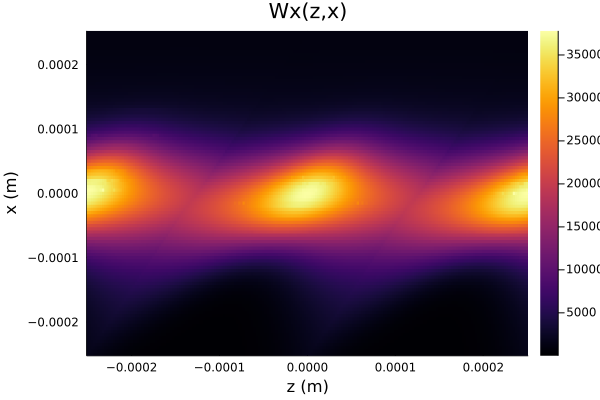

In [51]:
heatmap(zv, xv, AA_cpu, xlabel="z (m)", ylabel="x (m)", title="Wx(z,x)")

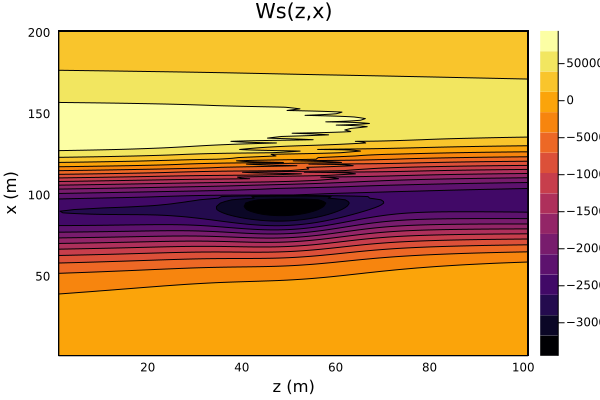

In [158]:
contourf(AA, xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

# Multi CPU

In [173]:
function Ws_case_B_multithread_phi(phi; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_B(z_ob[i], x_ob[j], gamma, phi, 101)
        end
    end
    return out
end

Ws_case_B_multithread_phi (generic function with 1 method)

In [16]:
phi_vec = [0.04, 0.06, 0.08, 0.1, 0.2];

In [174]:
Ws_caseB_mat_phi_004 = Ws_case_B_multithread_phi(0.04, nz=101, nx=3);

In [175]:
Ws_caseB_mat_phi_006 = Ws_case_B_multithread_phi(0.06, nz=101, nx=3);

In [176]:
Ws_caseB_mat_phi_008 = Ws_case_B_multithread_phi(0.08, nz=101, nx=3);

In [177]:
Ws_caseB_mat_phi_012 = Ws_case_B_multithread_phi(0.12, nz=101, nx=3);

In [178]:
Ws_caseB_mat_phi_02 = Ws_case_B_multithread_phi(0.2, nz=101, nx=3);

In [193]:
using DelimitedFiles

open("Ws_caseB_mat_phi_02.jl", "w") do io
    writedlm(io, Ws_caseB_mat_phi_02)
end

#kaka = readdlm("Ws_caseB_mat_phi_004.jl", '\t', '\n');

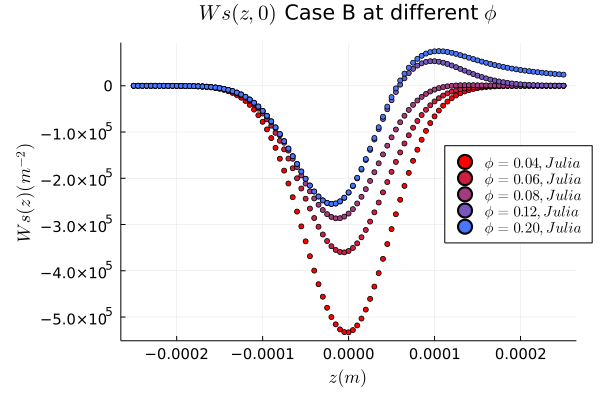

In [179]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseB_mat_phi_004[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseB_mat_phi_006[102:202], label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseB_mat_phi_008[102:202], label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseB_mat_phi_012[102:202], label=L"\phi=0.12, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseB_mat_phi_02[102:202], label=L"\phi=0.20, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])


#plot!(z_ob, WsB_int_vec_1, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[1])
#plot!(z_ob, WsB_int_vec_2, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[2])
#plot!(z_ob, WsB_int_vec_3, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[3])
#plot!(z_ob, WsB_int_vec_4, linewidth=2, label=L"\phi=0.12, 1D~ csr", color=cs1[4])
#plot!(z_ob, WsB_int_vec_5, linewidth=2, label=L"\phi=0.20, 1D~ csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case B at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=(0.8, 0.6), legendfontsize = 10)
#plot(z_ob, Ws_caseB_mat_phi_2[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])

# 1D theory

In [31]:
using QuadGK

lamb_1d(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2)
lamb_1d_prime(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2) * (-z / sigma_z^2)

z_L(phi::Float64) = rho*phi^3/24
coeff = -2/(3*rho^2)^(1/3)


# Case B boundary term ( for large phi this vanishes )
function Ws_case_B_1D_theory_boundary_term(z_ob::Float64, phi::Float64)
    #alternative form
    #return -4/phi/rho * lamb_1d( z_ob - rho*phi^3/24 )
    zL =  z_L(phi)
    return coeff* lamb_1d( z_ob - zL ) / zL^(1/3)
end



# Case B integral term ( for large phi this becomes the s-s wake )
function Ws_case_B_1D_theory_integral_term(z_ob::Float64, phi::Float64)
    w_ss(zp) = lamb_1d_prime(zp)/(z_ob - zp)^(1/3)
    return coeff*quadgk(w_ss, z_ob - z_L(phi), z_ob)[1]
end

# Case B Wx
function Wx_case_B_1D_theory(z_ob::Float64, phi::Float64)
    #alternative form
    return -4/rho * lamb_1d( z_ob )
end


# Case D boundary term ( for large phi_m this vanishes )
function Ws_case_D_1D_theory_boundary_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho   
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    
    return - 4 * lamb_1d(z_ob - delta_s(Lm))/(Lm + 2*x)
end

# Case D integral term
# Check Dave Sagan's paper for the change-of-variable version of the integral 
function Ws_case_D_1D_theory_integral_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho     
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    delta_s_prime(l) = l^2/8/rho^2*(l + 2*x)^2/(l + x)^2  
    ii(l) =  - 4/(l+2*x)* lamb_1d_prime(z_ob-delta_s(l))*delta_s_prime(l)
    
    return quadgk( ii, 0, Lm )[1]
end

Ws_case_D_1D_theory_integral_term (generic function with 1 method)

In [34]:
phi_ob = 0.01
WsB_1D(z_ob::Float64) = Ws_case_B_1D_theory_boundary_term(z_ob, phi_ob) + Ws_case_B_1D_theory_integral_term(z_ob, phi_ob)
WsB_1D(0.0);

In [35]:
phi_vec = [0.04, 0.06, 0.08, 0.12, 0.2];
phi_ob  = phi_vec[1]
WsB_int_vec_1 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[2]
WsB_int_vec_2 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[3]
WsB_int_vec_3 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[4]
WsB_int_vec_4 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[5]
WsB_int_vec_5 = map(WsB_1D, z_ob);